⚠️ No ZIP files found. Searching for already extracted images...
⚠️ No images found in extracted folder, trying direct search in /kaggle/input...
✅ Found 3264 images across 4 classes
🧾 Class distribution:
 class
meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: count, dtype: int64
📊 Train: 2219, Val: 392, Test: 653
Found 2219 validated image filenames belonging to 4 classes.
Found 392 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 118s 744ms/step - accuracy: 0.6543 - loss: 0.8559 - val_accuracy: 0.6913 - val_loss: 1.2833
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 427ms/step - accuracy: 0.9051 - loss: 0.2725 - val_accuracy: 0.8163 - val_loss: 0.5934
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 408ms/step - accuracy: 0.9434 - loss: 0.1419 - val_accuracy: 0.7679 - val_loss: 1.2849
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 427ms/step - accurac

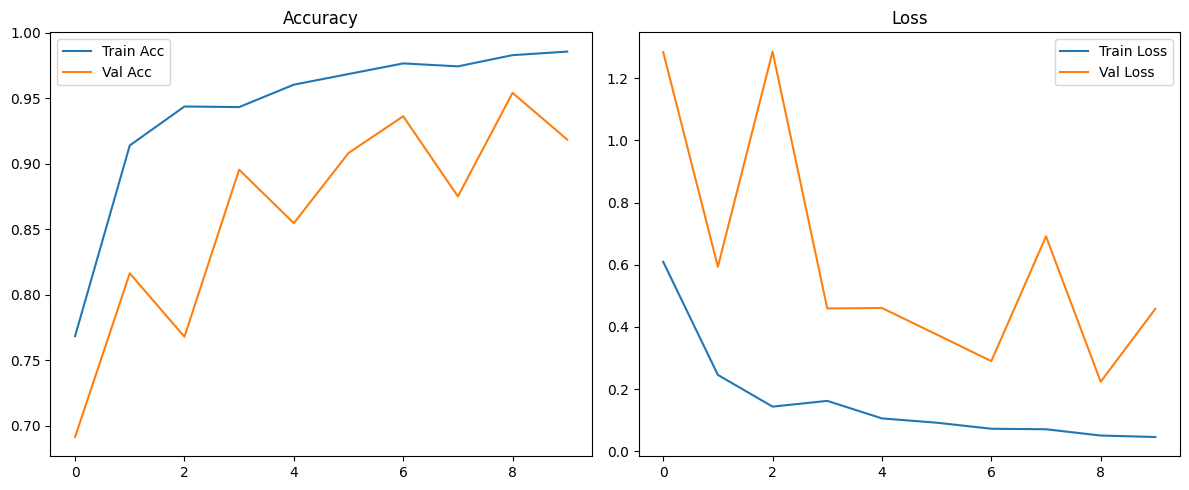

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step - accuracy: 0.9586 - loss: 0.1616
✅ Test Accuracy: 0.9510
📉 Test Loss: 0.1822
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.93      0.96      0.95       185
meningioma_tumor       0.94      0.92      0.93       188
        no_tumor       0.99      0.96      0.97       100
 pituitary_tumor       0.97      0.97      0.97       180

        accuracy                           0.95       653
       macro avg       0.96      0.95      0.95       653
    weighted avg       0.95      0.95      0.95       653



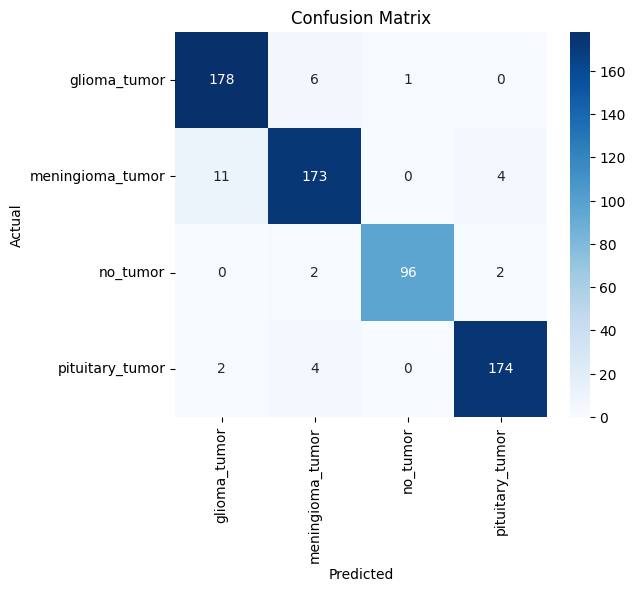

In [17]:
import os
import glob
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ======================
# ⚙️ Parameters
# ======================
DATASET_PATH = "/kaggle/input/figshare-dataset"   # Main dataset path
EXTRACT_PATH = "/kaggle/working/brain_tumor_dataset"
IMG_SIZE = (224, 224)  # ResNet50 expects 224x224
BATCH_SIZE = 32
EPOCHS = 10

# ======================
# 🗂 Step 0: Prepare dataset
# ======================
os.makedirs(EXTRACT_PATH, exist_ok=True)
zip_files = glob.glob(os.path.join(DATASET_PATH, "*.zip"))

if zip_files:
    # Extract all ZIPs found in main dataset path
    for file in zip_files:
        print(f"📦 Extracting {os.path.basename(file)}...")
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
else:
    print("⚠️ No ZIP files found. Searching for already extracted images...")
    # If no zips, copy all files from dataset path into working folder
    if not os.listdir(EXTRACT_PATH):  # Only copy if empty
        os.system(f"cp -r {DATASET_PATH}/* {EXTRACT_PATH} || true")

# ======================
# 🧠 Step 1: Search for images recursively
# ======================
image_paths = glob.glob(os.path.join(EXTRACT_PATH, "**", "*.*"), recursive=True)
image_paths = [p for p in image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg'))]

# If still empty, search directly inside /kaggle/input (fallback)
if len(image_paths) == 0:
    print("⚠️ No images found in extracted folder, trying direct search in /kaggle/input...")
    image_paths = glob.glob("/kaggle/input/**/*.jpg", recursive=True) + \
                  glob.glob("/kaggle/input/**/*.jpeg", recursive=True) + \
                  glob.glob("/kaggle/input/**/*.png", recursive=True)

if len(image_paths) == 0:
    raise ValueError("❌ No images found anywhere in dataset. Please check dataset path or upload again.")

# Extract class labels from folder structure
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
df = pd.DataFrame({'filename': image_paths, 'class': labels})

NUM_CLASSES = df['class'].nunique()
print(f"✅ Found {len(df)} images across {NUM_CLASSES} classes")
print("🧾 Class distribution:\n", df['class'].value_counts())

# ======================
# 🧪 Step 2: Split dataset
# ======================
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)
print(f"📊 Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ======================
# 🔄 Step 3: Data generators
# ======================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                              target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical')
val_gen = valid_datagen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical', shuffle=False)

# ======================
# 🔧 Step 4: Build ResNet50 model
# ======================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# ======================
# ⚙️ Step 5: Compile
# ======================
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ======================
# 📦 Step 6: Callbacks
# ======================
checkpoint = ModelCheckpoint('resnet50_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ======================
# 🏋️ Step 7: Train
# ======================
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, earlystop])

# ======================
# 📈 Step 8: Plot history
# ======================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ======================
# 🧪 Step 9: Evaluate on test set
# ======================
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")
print(f"📉 Test Loss: {loss:.4f}")

# ======================
# 🧾 Step 10: Classification report & confusion matrix
# ======================
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
